In [1]:
# import necessary modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import datasets

from utils import plot_costs

In this tutorial, you will learn

- How Gaussian Mixture Model predict new data.
- What are the parameters GMM learned from training in order to make predictions.
- As an Exepectation Maximization algorithm, How GMM learn these parameters.
    - What are the E (Expectation) step.
    - What are the M (Maximization) step.
- How to calculate the log likelihood.

Let's start with a example.

In [2]:
from gmm import GaussianMixture
from sklearn import mixture
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target, 
                                                    test_size = 0.25, 
                                                    random_state = 0,
                                                    stratify = iris.target)

n_classes = len(np.unique(y_train))

sk_gmm = mixture.GaussianMixture(n_components=3,
                                    covariance_type='full', 
                                    max_iter=20, 
                                    random_state=0)
sk_gmm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=20,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [4]:
print('sk train acc:', accuracy_score(y_true=y_train, y_pred=sk_gmm.predict(X_train)))
print('sk test acc:', accuracy_score(y_true=y_test, y_pred=sk_gmm.predict(X_test)))

sk train acc: 0.9107142857142857
sk test acc: 0.9210526315789473


Different that supervised learning, for unsupervised learning algorithm like GMM. You just fit it with `X_train` and tell it how many clusters you want. After the training, it can predict both old and new data with a descent accuracy. Now let's see what's the magic behind this learning algorithm. As usual, we start with the inference.

To predict `X`, we first need to calculate the joint log likelihood of `X`. Assuming that our training data are drawn from `n_components` Gaussian distributions, and we need to know the `mean_`, the `covariance_` of each Gaussian distribution and their relative `weights_`. If we have these parameters, we can calculate ll as

In [5]:
from scipy.stats import multivariate_normal as MVN
def _ll_joint(X, n_components, means_, covariances_, weights_):
    ll = np.empty((n_components, X.shape[0]))
    for k in range(n_components):
        mvn = MVN(mean=means_[k], cov=covariances_[k])
        ll[k] = mvn.logpdf(x=X) + np.log(weights_[k])
    return ll.T

Here `MVN` refers a multivariate normal distribution. So our goal is, given `n_components` and training data, learn `means_, covariances_, weights_` so we can predict new data.

In [6]:
def predict(X, n_components, means_, covariances_, weights_):
    ll = _ll_joint(X, n_components, means_, covariances_, weights_)
    return np.argmax(ll, axis=1)

The first step is to initialize these parameters.

We can randomly initialize these parameters and update them during training. But random initialize is not a good idea in unsupervised learning. It is considered best practice to initialize these parameters with `KMeans`.

In [7]:
m, n = X_train.shape
n_components = 3
resp = np.zeros((m, n_components))
kmeans = KMeans(n_clusters=n_components, random_state=0)
labels = kmeans.fit(X_train).labels_
resp[np.arange(m), labels] = 1

We get `labels` from `KMeans` and using one hot encoding assign the label to a matrix called `resp`.

In [8]:
resp[:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

Then we use `X` and `resp` to initialize `weights_`, `means_` and `covariances_`

- `total_weights_` are calculated by suming up the column vectors of `resp` as the number of data points in each component.
- Then we use dot product of `resp.T` and `X` to divided by the `total_weights_` to get the `means_` of each component.
- We update each compoents variance by theory.
- And finally we calculate the average `weights_`

In [9]:
def _update_covariances(resp, X, total_weights_, means_):
    """
    covariances_: shape(n_components, n_feature, n_feature)
    """
    covariances_ = np.empty((n_components, n, n))
    for k in range(n_components):
        diff = X - means_[k]
        covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / total_weights_[k]
    return covariances_

def _M_step(X, resp):
    """
    means_: shape(n_components, n_features)
    """
    total_weights_ = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    means_ = np.dot(resp.T, X) / total_weights_[:, np.newaxis]
    covariances_ = _update_covariances(resp, X, total_weights_, means_)
    weights_ = total_weights_ / m
    return means_, covariances_, weights_
means_, covariances_, weights_ = _M_step(X_train, resp)

In `_E_step`, we update `resp` using the updated `means_, covariances_, weights_` from `_M_step`

In [10]:
from scipy.special import softmax
def _E_step(X, n_components, means_, covariances_, weights_):
    ll = _ll_joint(X, n_components, means_, covariances_, weights_)
    resp = softmax(ll, axis=1)
    return resp

We iterate `_E_step` and `_M_step` to update these parameters.

In [11]:
max_iter = 20
for it in range(max_iter):
    # E-step
    resp = _E_step(X_train, n_components, means_, covariances_, weights_)

    # M-step
    means_, covariances_, weights_ = _M_step(X_train, resp)

Finally we can make predictions with them

In [12]:
train_preds = predict(X_train, n_components, means_, covariances_, weights_)
test_preds = predict(X_test, n_components, means_, covariances_, weights_)

accuracy_score(y_true=y_train, y_pred=train_preds)
accuracy_score(y_true=y_test, y_pred=test_preds)

0.9107142857142857

0.9210526315789473

In [13]:
gmm = GaussianMixture(n_components=3,
                        max_iter=20,
                        random_state=0,
                        abs_tol=1e-6,
                        rel_tol=1e-6,
                        verbose=0)
gmm.fit(X_train)
print('my train acc:', accuracy_score(y_true=y_train, y_pred=gmm.predict(X_train)))
print('my test acc:', accuracy_score(y_true=y_test, y_pred=gmm.predict(X_test)))

GaussianMixture(abs_tol=1e-06, covariance_type=None, max_iter=20,
                n_components=3, random_state=None, rel_tol=1e-06, verbose=0)

my train acc: 0.9107142857142857
my test acc: 0.9210526315789473


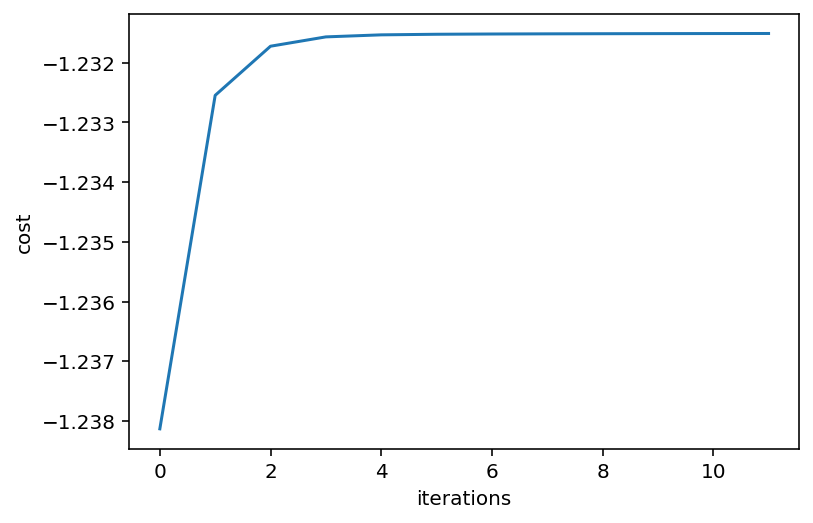

In [14]:
plot_costs(gmm)